## PINN para a Equação do Calor 1D

Este notebook implementa uma **Rede Neural Informada pela Física (PINN)** para resolver a Equação do Calor 1D.

A abordagem combina o aprendizado supervisionado tradicional com a imposição de uma restrição física (a própria equação diferencial parcial), permitindo que a rede neural aprenda a solução do problema em todo o domínio espaço-tempo.

### A Equação do Calor 1D Transiente

A equação governante do fenômeno é:

$$ \frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} $$

Onde:
- $T$ é a temperatura.
- $t$ é o tempo.
- $x$ é a posição.
- $\alpha$ é a difusividade térmica do material (uma constante).

A rede neural será treinada para aproximar a função $T(x, t)$. A função de perda total será uma combinação de:

1.  **Perda de Dados (MSE):** O erro entre a previsão da rede e os dados de medição fornecidos.
2.  **Perda da Física (Residual da PDE):** Uma medida de quanto a saída da rede viola a equação do calor.

### Resumo do Procedimento

1.  **Carregar e Preparar Dados**: Carregue seu `df` e crie tensores para as posições `(x, t)` e temperaturas `T`.
2.  **Gerar Pontos de Colocação**: Crie um conjunto de pontos `(x, t)` aleatórios dentro do seu domínio para avaliar a perda da física.
3.  **Definir o Modelo**: Crie uma rede neural sequencial com Keras que mapeia `(x, t)` para `T`.
4.  **Implementar as Funções de Perda**:
    - `data_loss`: MSE entre as previsões e os dados reais.
    - `physics_loss`: MSE do residual da PDE, calculado usando `tf.GradientTape` para obter as derivadas.
5.  **Criar o Loop de Treinamento**:
    - Em cada época, calcule a perda de dados e a perda da física.
    - Some-as para obter a perda total.
    - Use `tf.GradientTape` para encontrar os gradientes da perda total em relação aos pesos do modelo.
    - Aplique esses gradientes usando um otimizador como o Adam.
6.  **Treinar e Avaliar**: Execute o loop por um número suficiente de épocas e, ao final, use o `pinn_model` treinado para fazer previsões e visualizar a solução.

### Importações

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

tf.random.set_seed(42)
np.random.seed(42)

2025-09-27 18:22:16.830545: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-27 18:22:16.831331: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-27 18:22:16.887788: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-27 18:22:18.223378: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

### Leitura e Preparação dos Dados

E0000 00:00:1759008139.437621   35155 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1759008139.460080   35155 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


(0.0, 10.0)

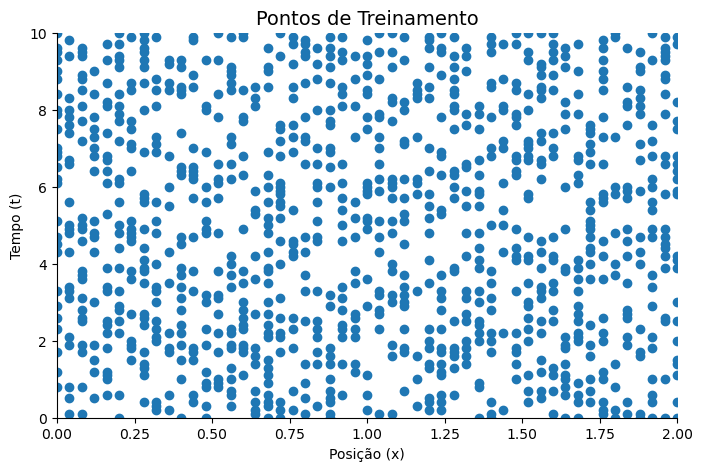

In [2]:
# Parâmetros do problema
ALPHA = 0.05

# Leitura dos dados
df_full = pd.read_csv("../../00-scientific_computer/data/problem1.csv")
df = df_full.sample(frac=0.2, random_state=42)

# Dados completos, entrada (x, t) e saída (T)
X = df_full[["position", "time"]].values
T = df_full[["temperature"]].values

# Dados de treino
X_train_raw = df[["position", "time"]].values
T_train_raw = df[["temperature"]].values

# Converte para tensores do TensorFlow
X_train_tf = tf.convert_to_tensor(X_train_raw, dtype=tf.float32)
T_train_tf = tf.convert_to_tensor(T_train_raw, dtype=tf.float32)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(X_train_raw[:, 0], X_train_raw[:, 1])

ax.set_title("Pontos de Treinamento", fontsize=14)
ax.set_xlabel("Posição (x)", fontsize=10)
ax.set_ylabel("Tempo (t)", fontsize=10)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim([X[:, 0].min(), X[:, 0].max()])
ax.set_ylim([X[:, 1].min(), X[:, 1].max()])

### Normalização dos Dados

Normalizamos as entradas para a faixa `[0, 1]` para melhorar a estabilidade e a velocidade do treinamento.

Os dados de saída já estão na faixa `[-1, 1]`, não necessitando a normalização.

In [3]:
scaler_X = MinMaxScaler()
scaler_X.fit(X_train_raw)

# Ajusta e transforma os dados
X_train_norm = scaler_X.transform(X_train_raw)
X_test_norm = scaler_X.transform(X)

# Converte de volta para tensores
X_train_norm_tf = tf.convert_to_tensor(X_train_norm, dtype=tf.float32)

### Geração dos Pontos de Colocação

Estes são os pontos no interior do domínio onde não conhecemos a temperatura. Eles serão usados para calcular a **perda da física** ($L_{física}$), forçando a rede a obedecer à equação do calor.

(0.0, 10.0)

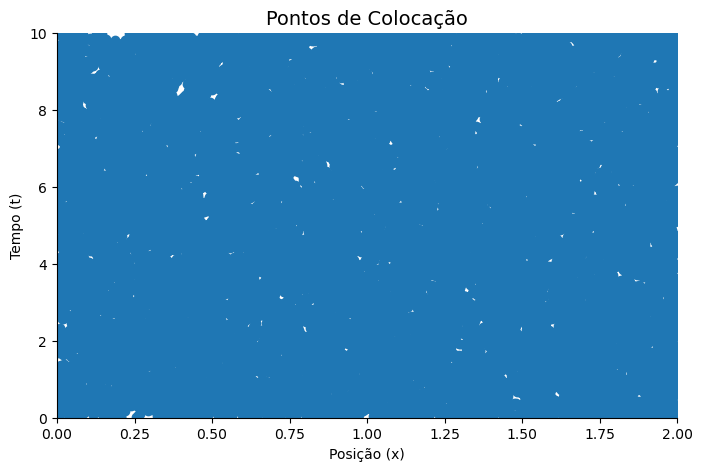

In [4]:
N_collocation = 20000

# Pega os limites do domínio a partir dos dados
x_min, x_max = df["position"].min(), df["position"].max()
t_min, t_max = df["time"].min(), df["time"].max()

# Gera pontos aleatórios dentro desses limites
x_collocation = tf.random.uniform(
    (N_collocation, 1), minval=x_min, maxval=x_max, dtype=tf.float32
)
t_collocation = tf.random.uniform(
    (N_collocation, 1), minval=t_min, maxval=t_max, dtype=tf.float32
)
X_collocation_raw = tf.concat([x_collocation, t_collocation], axis=1)

# Normaliza os pontos de colocação
X_collocation_norm = scaler_X.transform(X_collocation_raw)
X_collocation_norm_tf = tf.convert_to_tensor(X_collocation_norm, dtype=tf.float32)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(X_collocation_raw[:, 0], X_collocation_raw[:, 1])

ax.set_title("Pontos de Colocação", fontsize=14)
ax.set_xlabel("Posição (x)", fontsize=10)
ax.set_ylabel("Tempo (t)", fontsize=10)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim([x_min, x_max])
ax.set_ylim([t_min, t_max])

### Construção do Modelo (Rede Neural)

In [5]:
def create_pinn_model(num_hidden_layers=5, num_neurons=128):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=(2,)))

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons, activation="tanh"))

    model.add(tf.keras.layers.Dense(1, activation="linear"))

    return model


pinn_model = create_pinn_model()
pinn_model.summary()

/home/thiag/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,561 (260.00 KB)

 Trainable params: 66,561 (260.00 KB)

 Non-trainable params: 0 (0.00 B)

### Função de Perda Híbrida

A função de perda total é a soma da perda nos dados e da perda na física. Aqui, implementamos o cálculo do resíduo da EDP, aplicando a Regra da Cadeia para corrigir as derivadas devido à normalização.

In [6]:
# Fatores de escala para a regra da cadeia
# scale_ é 1/(max-min), então o range é 1/scale_
x_range = 1 / scaler_X.scale_[0]
t_range = 1 / scaler_X.scale_[1]


def physics_loss(model, x_norm, t_norm):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_norm)
        tape.watch(t_norm)

        X_norm_concat = tf.concat([x_norm, t_norm], axis=1)
        T_pred = model(X_norm_concat)

        dT_dx_norm = tape.gradient(T_pred, x_norm)
        dT_dt_norm = tape.gradient(T_pred, t_norm)
        d2T_dx2_norm = tape.gradient(dT_dx_norm, x_norm)

    del tape

    # Aplicação da regra da cadeira para correção da normalização
    dT_dt = dT_dt_norm / t_range
    d2T_dx2 = d2T_dx2_norm / (x_range**2)

    # Resíduo da EDP
    residual = dT_dt - ALPHA * d2T_dx2

    return tf.reduce_mean(tf.square(residual))


def data_loss(model, X_data_norm, T_data):
    T_pred = model(X_data_norm)
    return tf.reduce_mean(tf.square(T_pred - T_data))

### Loop de Treinamento Customizado

Usamos um loop customizado para calcular as perdas e aplicar os gradientes a cada época.

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)


# Usamos @tf.function para compilar o passo de treino e torná-lo mais rápido
@tf.function
def train_step(model, X_data, T_data, X_collocation):
    with tf.GradientTape() as tape:
        loss_d = data_loss(model, X_data, T_data)
        loss_p = physics_loss(model, X_collocation[:, 0:1], X_collocation[:, 1:2])

        # Começamos com um peso igual para ambas as perdas
        total_loss = loss_d + loss_p

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_d, loss_p, total_loss


EPOCHS = 1000
history = []

for epoch in range(EPOCHS):
    loss_d, loss_p, total_loss = train_step(
        pinn_model, X_train_norm_tf, T_train_tf, X_collocation_norm_tf
    )
    history.append([loss_d.numpy(), loss_p.numpy(), total_loss.numpy()])

    if (epoch + 1) % 1000 == 0:
        print(
            f"Epoch {epoch+1:5d}, Loss_Data: {loss_d:.4e}, Loss_Physics: {loss_p:.4e}, Loss_Total: {total_loss:.4e}"
        )

Epoch  1000, Loss_Data: 6.5918e-02, Loss_Physics: 1.4619e-02, Loss_Total: 8.0536e-02


### Análise da Convergência

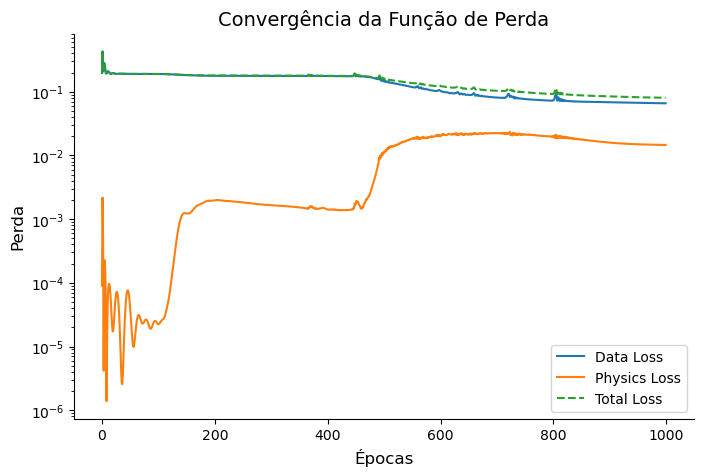

In [8]:
history = np.array(history)

plt.figure(figsize=(8, 5))

plt.plot(history[:, 0], label="Data Loss")
plt.plot(history[:, 1], label="Physics Loss")
plt.plot(history[:, 2], label="Total Loss", linestyle="--")

plt.yscale("log")

plt.title("Convergência da Função de Perda", fontsize=14)
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("Perda", fontsize=12)
plt.legend()

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

### Métricas de Avaliação

Agora, usamos o modelo treinado para prever a temperatura em todo o domínio e comparamos com os dados de treinamento originais.

In [12]:
# Fazer previsões nos mesmos pontos do DataFrame de treinamento
T_pred = pinn_model.predict(X_test_norm)

# Calcular as métricas de erro
mse = mean_squared_error(T, T_pred)
mae = mean_absolute_error(T, T_pred)
r2 = r2_score(T, T_pred)

print(f"Erro Quadrático Médio (MSE): {mse:.6f}")
print(f"Erro Absoluto Médio (MAE):  {mae:.6f}")
print(f"R2 Score:  {r2:.6f}")

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
Erro Quadrático Médio (MSE): 0.067985
Erro Absoluto Médio (MAE):  0.201335
R2 Score:  0.642213


### Visualização dos Resultados

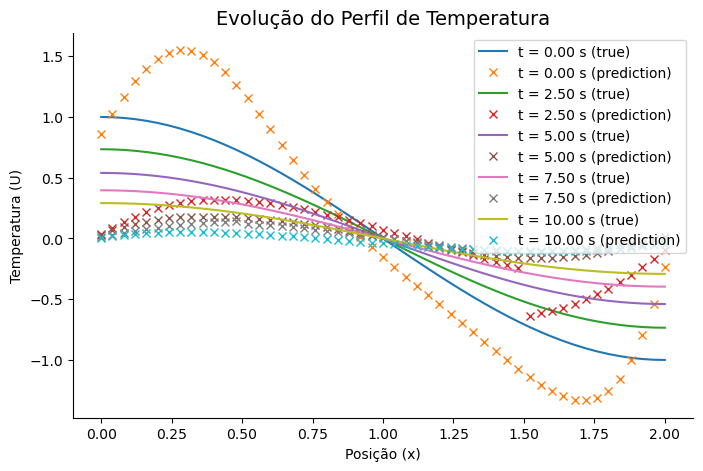

In [10]:
# Perfis de Temperatura ao Longo do Tempo

x = np.unique(X[:, 0])
t = np.unique(X[:, 1])

Nx = len(x)
Nt = len(t)

U_sol = T.reshape([Nt, Nx])
U_pred = T_pred.reshape([Nt, Nx])

fig, ax = plt.subplots(figsize=(8, 5))

indices_tempo = [0, Nt // 4, Nt // 2, 3 * Nt // 4, Nt - 1]  # Pega 5 instantes de tempo
for i, t_idx in enumerate(indices_tempo):
    ax.plot(x, U_sol[t_idx, :], label=f"t = {t[t_idx]:.2f} s (true)")
    ax.plot(x, U_pred[t_idx, :], "x", label=f"t = {t[t_idx]:.2f} s (prediction)")

ax.set_title("Evolução do Perfil de Temperatura", fontsize=14)
ax.set_xlabel("Posição (x)", fontsize=10)
ax.set_ylabel("Temperatura (U)", fontsize=10)
ax.legend()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

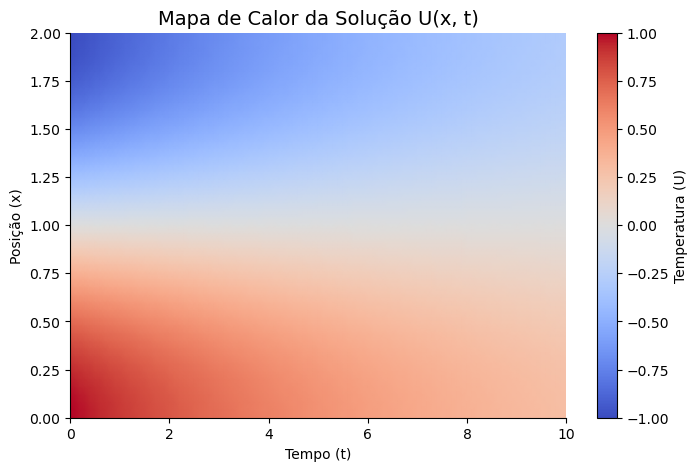

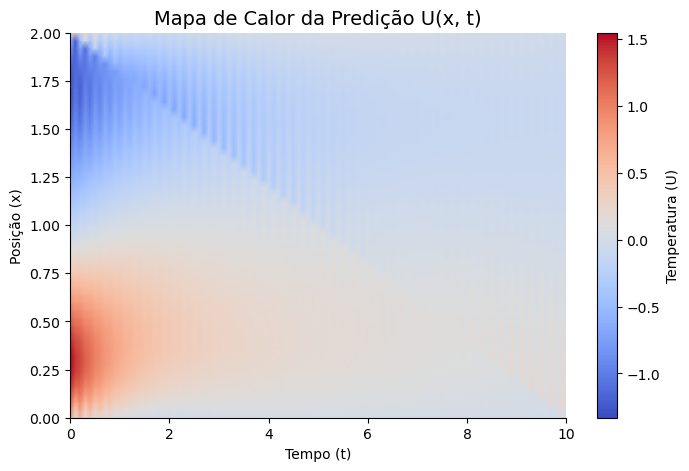

In [11]:
# Mapa de Calor U(x, t) - Valores Reais

fig, ax = plt.subplots(figsize=(8, 5))

# Meshgrid para as coordenadas. Note que pcolormesh usa as coordenadas dos cantos.
T_grid, X_grid = np.meshgrid(t, x)

# A matriz de cores (U_sol.T) deve ter dimensões (Nx, Nt)
# Usamos shading='gouraud' para interpolação suave de cores.
im = ax.pcolormesh(T_grid, X_grid, U_sol.T, cmap="coolwarm", shading="gouraud")

# Adiciona a barra de cores
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Temperatura (U)", fontsize=10)

ax.set_title("Mapa de Calor da Solução U(x, t)", fontsize=14)
ax.set_xlabel("Tempo (t)", fontsize=10)
ax.set_ylabel("Posição (x)", fontsize=10)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Mapa de Calor U(x, t) - Valores Previstos

fig, ax = plt.subplots(figsize=(8, 5))
im = ax.pcolormesh(T_grid, X_grid, U_pred.T, cmap="coolwarm", shading="gouraud")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Temperatura (U)", fontsize=10)

ax.set_title("Mapa de Calor da Predição U(x, t)", fontsize=14)
ax.set_xlabel("Tempo (t)", fontsize=10)
ax.set_ylabel("Posição (x)", fontsize=10)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)